# Single sample intracellular signalling network inference

In this notebook we showcase how to use the advanced CARNIVAL implementation available in CORNETO. This implementation extends the capabilities of the original CARNIVAL method by enabling advanced modelling and injection of knowledge for hypothesis generation. We will use a dataset consisting of 6 samples of hepatic stellate cells (HSC) where three of them were activated by the cytokine Transforming growth factor (TGF-β). 

In the first part, we will show how to estimate Transcription Factor activities from gene expression data, following the [Decoupler tutorial](https://decoupler-py.readthedocs.io/en/latest/notebooks/bulk.html) for functional analysis. Then, we will use the CARNIVAL method available in CORNETO to infer a network from TFs to receptors, assuming that we don't really know which treatment was used. We will see how to do some basic modeling and adding information from pathway enrichment using PROGENy to bias the inferred networks.

> **NOTE:** This tutorial uses the new **Decoupler v2** version. We also use the **highs** solver, which has to be installed with `pip install highspy`

In [1]:
import gzip
import os
import shutil
import tempfile
import urllib.request
import pandas as pd

# https://decoupler-py.readthedocs.io
import decoupler as dc
import numpy as np

# https://omnipathdb.org/
import omnipath as op

# Pydeseq for differential expression analysis
from pydeseq2.dds import DefaultInference, DeseqDataSet
from pydeseq2.ds import DeseqStats

# https://corneto.org
import corneto as cn

2025-06-11 18:18:58 | [INFO] Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2025-06-11 18:18:58 | [INFO] Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2025-06-11 18:18:59 | [INFO] Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2025-06-11 18:18:59 | [INFO] Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2025-06-11 18:18:59 | [INFO] Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2025-06-11 18:18:59 | [INFO] Downloading data from `https://omnipathdb.org/about?format=text`


In [2]:
dc.__version__

'2.0.4'

In [3]:
max_time = 300
seed = 0

In [4]:
# Load the dataset
adata = dc.ds.hsctgfb()
adata

AnnData object with n_obs × n_vars = 6 × 58674
    obs: 'condition', 'sample_id'

## Data preprocessing

We will use AnnData and PyDeseq2 to pre-process the data and compute differential expression between control and tretament

In [5]:
# Obtain genes that pass the thresholds
dc.pp.filter_by_expr(
    adata=adata,
    group="condition",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)
adata

AnnData object with n_obs × n_vars = 6 × 19510
    obs: 'condition', 'sample_id'

In [6]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=adata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(dds, contrast=["condition", "treatment", "control"], inference=inference)

# Compute Wald test
stat_res.summary()

Using None as control genes, passed at DeseqDataSet initialization


/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_14241/732451786.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.71 seconds.

Fitting dispersion trend curve...
... done in 0.16 seconds.

Fitting MAP dispersions...
... done in 0.84 seconds.

Fitting LFCs...
... done in 0.44 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition treatment vs control
                  baseMean  log2FoldChange     lfcSE       stat  \
RP11-347I19.8    88.877997       -0.207119  0.252510  -0.820242   
TMEM170B        103.807801       -0.276960  0.210533  -1.315516   
RP11-91P24.6    185.514929       -0.305844  0.180907  -1.690620   
SLC33A1        2559.269047        0.595912  0.085251   6.990075   
SNORA61          66.168502        0.746772  0.266416   2.803032   
...                    ...             ...       ...        ...   
RP11-75I2.3     771.828248        3.812419  0.128104  29.760449   
SLC25A24       3525.523888        0.651017  0.087598   7.431841   
BTN2A2          674.018191       -0.107905  0.106212  -1.015945   
RP11-101E3.5    194.084339        0.092515  0.181943   0.508484   
RP11-91I8.3      10.761886       -3.804522  0.920080  -4.134989   

                      pvalue           padj  
RP11-347I19.8   4.120781e-01   5.540360e-01  
TMEM170B        1.883365e-01   3.0

... done in 0.31 seconds.



In [7]:
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
RP11-347I19.8,88.877997,-0.207119,0.252510,-0.820242,4.120781e-01,5.540360e-01
TMEM170B,103.807801,-0.276960,0.210533,-1.315516,1.883365e-01,3.052879e-01
RP11-91P24.6,185.514929,-0.305844,0.180907,-1.690620,9.090941e-02,1.681656e-01
SLC33A1,2559.269047,0.595912,0.085251,6.990075,2.747400e-12,2.423226e-11
SNORA61,66.168502,0.746772,0.266416,2.803032,5.062459e-03,1.380028e-02
...,...,...,...,...,...,...
RP11-75I2.3,771.828248,3.812419,0.128104,29.760449,1.270300e-194,4.130591e-192
SLC25A24,3525.523888,0.651017,0.087598,7.431841,1.070963e-13,1.049974e-12
BTN2A2,674.018191,-0.107905,0.106212,-1.015945,3.096555e-01,4.491264e-01
RP11-101E3.5,194.084339,0.092515,0.181943,0.508484,6.111136e-01,7.290020e-01


In [8]:
data = results_df[["stat"]].T.rename(index={"stat": "treatment.vs.control"})
data

,RP11-347I19.8,TMEM170B,RP11-91P24.6,SLC33A1,SNORA61,THAP9-AS1,LIX1L,TTC8,WBSCR22,LPHN2,...,STARD4-AS1,ZNF845,NIPSNAP3B,ARL6IP5,MATN1-AS1,RP11-75I2.3,SLC25A24,BTN2A2,RP11-101E3.5,RP11-91I8.3
treatment.vs.control,-0.820242,-1.315516,-1.69062,6.990075,2.803032,1.531275,2.164138,-0.579879,-0.945672,-14.351588,...,14.484214,0.56727,-1.883272,-8.42519,-1.739921,29.760449,7.431841,-1.015945,0.508484,-4.134989


## Prior knowledge with Decoupler and Omnipath

In [9]:
# Retrieve CollecTRI gene regulatory network (through Omnipath).
# These are regulons that we will use for enrichment tests
# to infer TF activities
collectri = dc.op.collectri(organism="human")
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


In [10]:
# Run
tf_acts, tf_padj = dc.mt.ulm(data=data, net=collectri)

# Filter by sign padj
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

tf_acts

,APEX1,ARID1A,ARID4B,ARNT,ASXL1,ATF6,BARX2,BCL11A,BCL11B,BMAL2,...,TBX10,TCF21,TFAP2C,TP53,VEZF1,WWTR1,ZBTB33,ZEB2,ZNF804A,ZXDC
treatment.vs.control,-2.65907,-3.917428,-2.808733,3.174004,3.747021,2.707775,5.35855,2.649554,-4.204618,3.869672,...,-3.705089,6.163829,-2.579863,-3.571649,4.208695,-3.968034,3.238391,5.791132,3.366525,-2.734602


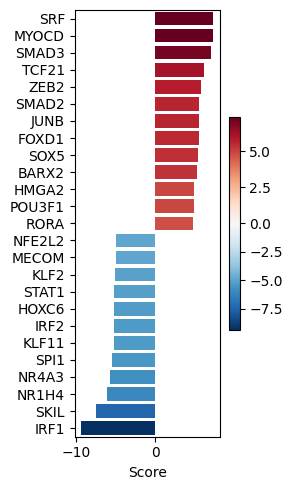

In [11]:
dc.pl.barplot(data=tf_acts, name="treatment.vs.control", top=25, figsize=(3, 5))

In [12]:
# We obtain ligand-receptor interactions from Omnipath, and we keep only the receptors
# This is our list of a prior potential receptors from which we will infer the network
unique_receptors = set(op.interactions.LigRecExtra.get(genesymbols=True)["target_genesymbol"].values.tolist())
len(unique_receptors)

1201

In [13]:
df_de_receptors = results_df.loc[results_df.index.intersection(unique_receptors)]
df_de_receptors = df_de_receptors[df_de_receptors.pvalue <= 1e-3]
df_de_receptors = df_de_receptors.sort_values(by="stat", ascending=False)
df_de_receptors

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CDH6,28267.981856,3.020228,0.077434,39.003986,0.000000e+00,0.000000e+00
CRLF1,7921.375581,3.342105,0.088004,37.976732,0.000000e+00,0.000000e+00
FZD8,2720.368078,3.843472,0.102667,37.436438,9.984600e-307,1.025261e-303
CDH2,7112.916583,2.809906,0.081906,34.306464,6.285559e-258,3.606802e-255
DYSF,441.551809,4.593718,0.182110,25.225001,2.130572e-140,3.711381e-138
...,...,...,...,...,...,...
TNFRSF1B,646.930651,-3.540723,0.137121,-25.821870,5.038067e-147,9.542979e-145
CHRM2,5807.106139,-2.477402,0.086007,-28.804799,1.867752e-182,5.521189e-180
TNFRSF19,4210.866189,-3.038970,0.101233,-30.019698,5.430089e-198,1.858615e-195
LPAR1,12716.045776,-2.581318,0.070856,-36.430237,1.414312e-290,1.103729e-287


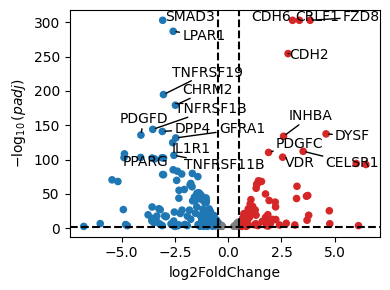

In [14]:
dc.pl.volcano(
    data=df_de_receptors,
    x="log2FoldChange",
    y="padj",
    top=20,
)

In [15]:
# We will take the top 20 receptors that increased the expression after treatment
df_top_receptors = df_de_receptors.head(20)
df_top_receptors

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CDH6,28267.981856,3.020228,0.077434,39.003986,0.000000e+00,0.000000e+00
CRLF1,7921.375581,3.342105,0.088004,37.976732,0.000000e+00,0.000000e+00
FZD8,2720.368078,3.843472,0.102667,37.436438,9.984600e-307,1.025261e-303
CDH2,7112.916583,2.809906,0.081906,34.306464,6.285559e-258,3.606802e-255
DYSF,441.551809,4.593718,0.182110,25.225001,2.130572e-140,3.711381e-138
INHBA,24333.979039,2.599031,0.104354,24.905991,6.407468e-137,1.041748e-134
CELSR1,492.430456,3.517760,0.154404,22.782885,6.777783e-115,8.815637e-113
PDGFC,5482.100375,1.895284,0.083804,22.615764,3.032358e-113,3.917967e-111
VDR,1450.584956,2.555486,0.116713,21.895517,2.866339e-106,3.389228e-104
HHIP,379.147209,6.006281,0.287273,20.907896,4.538088e-97,4.426905e-95


## Inferring intracellular signalling network with CARNIVAL and CORNETO

CORNETO is a unified framework for knowledge-driven network inference. It includes a very flexible implementation of CARNIVAL that expands its original capabilities. We will see how to use it under different assumptions to extract a network from a prior knowledge network and a set of potential receptors + our estimated TFs


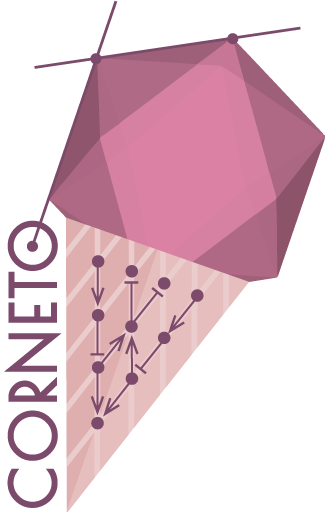

In [16]:
cn.info()

In [17]:
from corneto.methods.future import CarnivalFlow

CarnivalFlow.show_references()

In [18]:
# We get only interactions from SIGNOR http://signor.uniroma2.it/
pkn = op.interactions.OmniPath.get(databases=["SIGNOR"], genesymbols=True)
pkn = pkn[pkn.consensus_direction == True]
pkn.head()

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,Q13976,Q13507,PRKG1,TRPC3,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
1,Q13976,Q9HCX4,PRKG1,TRPC7,True,True,False,True,True,False,3,SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151,SIGNOR;TRIP;iPTMnet,3,3,1,21402151
2,Q13438,Q9HBA0,OS9,TRPV4,True,True,True,True,True,True,3,HPRD:17932042;SIGNOR:17932042;TRIP:17932042,HPRD;SIGNOR;TRIP,3,3,1,17932042
3,P18031,Q9H1D0,PTPN1,TRPV6,True,False,True,True,False,True,11,DEPOD:15894168;DEPOD:17197020;HPRD:15894168;In...,DEPOD;HPRD;IntAct;Lit-BM-17;SIGNOR;SPIKE_LC;TRIP,7,6,2,15894168;17197020
4,P63244,Q9BX84,RACK1,TRPM6,True,False,True,True,False,True,2,SIGNOR:18258429;TRIP:18258429,SIGNOR;TRIP,2,2,1,18258429


In [19]:
pkn["interaction"] = pkn["is_stimulation"].astype(int) - pkn["is_inhibition"].astype(int)
sel_pkn = pkn[["source_genesymbol", "interaction", "target_genesymbol"]]
sel_pkn

,source_genesymbol,interaction,target_genesymbol
0,PRKG1,-1,TRPC3
1,PRKG1,1,TRPC7
2,OS9,0,TRPV4
3,PTPN1,-1,TRPV6
4,RACK1,-1,TRPM6
...,...,...,...
61542,APC_PUF60_SIAH1_SKP1_TBL1X,-1,CTNNB1
61543,MAP2K6,1,MAPK10
61544,PRKAA1,1,TP53
61545,CNOT1_CNOT10_CNOT11_CNOT2_CNOT3_CNOT4_CNOT6_CN...,-1,NANOS2


In [20]:
# We create the CORNETO graph by importing the edges and interaction
from corneto.io import load_graph_from_sif_tuples

G = load_graph_from_sif_tuples([(r[0], r[1], r[2]) for _, r in sel_pkn.iterrows() if r[1] != 0])
G.shape

(5442, 60034)

In [21]:
# As measurements, we take the estimated TFs, we will filter out TFs with p-val > 0.001
significant_tfs = tf_acts[tf_padj <= 0.001].T.dropna().sort_values(by="treatment.vs.control", ascending=False)
significant_tfs

,treatment.vs.control
SRF,7.386495
MYOCD,7.347742
SMAD3,7.088954
TCF21,6.163829
ZEB2,5.791132
SMAD2,5.618762
JUNB,5.615222
FOXD1,5.569866
SOX5,5.389520
BARX2,5.358550


In [22]:
# We keep only the ones in the PKN graph
measurements = significant_tfs.loc[significant_tfs.index.intersection(G.V)].to_dict()["treatment.vs.control"]
measurements

{'SRF': 7.386495312851475,
 'MYOCD': 7.3477418488593,
 'SMAD3': 7.088953922116064,
 'ZEB2': 5.7911322785963435,
 'SMAD2': 5.618762357005816,
 'JUNB': 5.615222387859854,
 'HMGA2': 4.922227935739035,
 'POU3F1': 4.907624790924594,
 'RORA': 4.752798433353922,
 'SMAD4': 4.444090714736604,
 'MEF2A': 4.237091117534177,
 'FGF2': 4.210588858175027,
 'SMAD5': -4.006207147710557,
 'CIITA': -4.1357011230543845,
 'NFKBIB': -4.156185003186268,
 'REL': -4.1668552776199554,
 'PITX3': -4.20041706737378,
 'IRF3': -4.274768908592069,
 'PITX1': -4.3434055546060915,
 'KLF8': -4.469643880727271,
 'DNMT3A': -4.64277743087254,
 'RELB': -4.684387581686191,
 'NFE2L2': -4.912649636784848,
 'MECOM': -4.945146818217912,
 'STAT1': -5.190882487350966,
 'HOXC6': -5.261961030902404,
 'IRF2': -5.272425389933752,
 'KLF11': -5.272848781428293,
 'SPI1': -5.424462691953871,
 'NR4A3': -5.726818220249099,
 'NR1H4': -6.058745290814488,
 'SKIL': -7.437972448180294,
 'IRF1': -9.363009055573007}

In [23]:
# We will infer the direction, so for the inputs, we use a value of 0 (=unknown direction)
inputs = {k: 0 for k in df_top_receptors.index.intersection(G.V).values}
inputs

{'CDH6': 0,
 'CRLF1': 0,
 'FZD8': 0,
 'CDH2': 0,
 'INHBA': 0,
 'VDR': 0,
 'IGF1': 0,
 'EFNB2': 0,
 'ITGB3': 0,
 'TGFB1': 0,
 'IL21R': 0,
 'EGF': 0,
 'ITGA11': 0}

In [24]:
# Create the dataset in standard format
carnival_data = dict()
for inp, v in inputs.items():
    carnival_data[inp] = dict(value=v, role="input", mapping="vertex")
for out, v in measurements.items():
    carnival_data[out] = dict(value=v, role="output", mapping="vertex")
data = cn.Data.from_cdict({"sample1": carnival_data})
data

Data(n_samples=1, n_feats=[46])

## CARNIVAL

We will use now the standard CARNIVAL with a regularization penalty of 0.5. Typically, we would need additional data or information to select the optimal parameter. For hypothesis exploration, we can try different values and manually inspect the solutions

In [25]:
carnival = CarnivalFlow(lambda_reg=0.5)
P = carnival.build(G, data)
P.expr

Unreachable vertices for sample: 0


{'_flow': _flow: Variable((3279,), _flow),
 'edge_activates': edge_activates: Variable((3279, 1), edge_activates, boolean=True),
 'edge_inhibits': edge_inhibits: Variable((3279, 1), edge_inhibits, boolean=True),
 'const0x94da39a381f04fe': const0x94da39a381f04fe: Constant(CONSTANT, NONNEGATIVE, (947, 3279)),
 '_dag_layer': _dag_layer: Variable((947, 1), _dag_layer),
 'const0x1aa7a82deb9aa0b6': const0x1aa7a82deb9aa0b6: Constant(CONSTANT, NONNEGATIVE, (947, 3279)),
 'flow': _flow: Variable((3279,), _flow),
 'vertex_value': Expression(AFFINE, UNKNOWN, (947, 1)),
 'vertex_activated': Expression(AFFINE, NONNEGATIVE, (947, 1)),
 'vertex_inhibited': Expression(AFFINE, NONNEGATIVE, (947, 1)),
 'edge_value': Expression(AFFINE, UNKNOWN, (3279, 1)),
 'edge_has_signal': Expression(AFFINE, NONNEGATIVE, (3279, 1)),
 'vertex_max_depth': _dag_layer: Variable((947, 1), _dag_layer)}

In [26]:
P.solve(solver="highs", max_seconds=60, verbosity=1);

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 11 06:19:10 PM: Your problem has 10784 variables, 30852 constraints, and 1 parameters.
(CVXPY) Jun 11 06:19:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 06:19:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 11 06:19:10 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 11 06:19:10 PM: Compiling problem (target solver=HIGHS).
(CVXPY) Jun 11 06:19:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> HIGHS
(CVXPY) Jun 11 06:19:10 P

In [27]:
# Error for sample is 0, meaning that all reachable TFs (from receptors) are correctly explained
for o in P.objectives:
    print(o.name, "->", o.value)

error_sample1_0 -> 1.050898412285121e-15
regularization_edge_has_signal -> 53.0


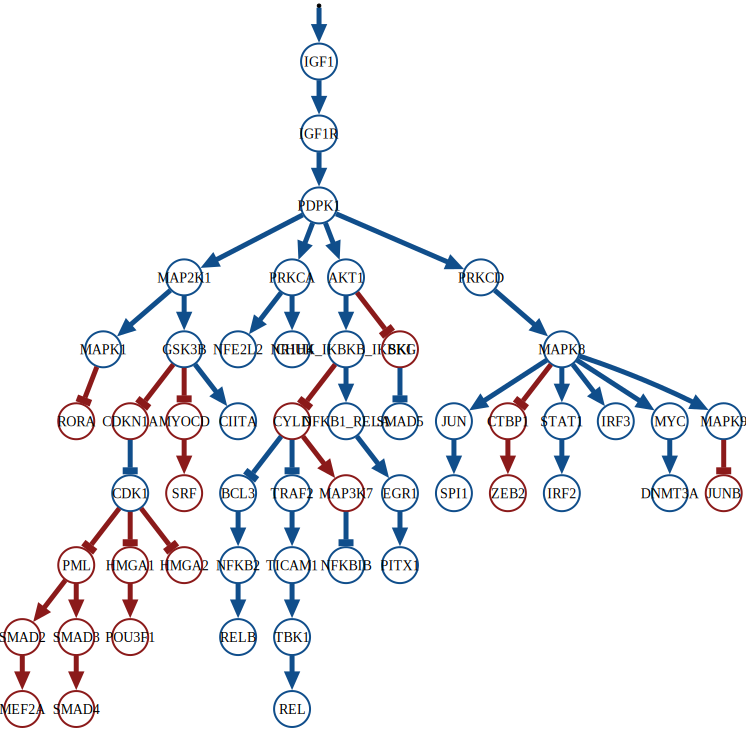

In [28]:
# We extract the selected edges
sol_edges = np.flatnonzero(np.abs(P.expr.edge_value.value) > 0.5)
carnival.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value,
    edge_values=P.expr.edge_value.value,
    edge_indexes=sol_edges,
)

In [29]:
# Extracting the solution graph
G_sol = carnival.processed_graph.edge_subgraph(sol_edges)
G_sol.shape

(53, 53)

In [30]:
pd.DataFrame(
    P.expr.vertex_value.value,
    index=carnival.processed_graph.V,
    columns=["node_activity"],
)

,node_activity
PTPRC,0.0
GEM,0.0
MYO10,0.0
ARHGEF12,0.0
TP53RK,0.0
...,...
NUAK1,0.0
CAMKK2,0.0
P0C725_UBB,0.0
CSNK2B,0.0


In [31]:
pd.DataFrame(P.expr.edge_value.value, index=carnival.processed_graph.E, columns=["edge_activity"])

edge_activity
(SMAD3)                                (MYOD1)               0.0
(GRK2)                                 (BDKRB2)              0.0
(MAPK14)                               (MAPKAPK2)            0.0
(DEPTOR_EEF1A1_MLST8_MTOR_PRR5_RICTOR) (FBXW8)               0.0
(SLK)                                  (MAP3K5)              0.0
...                                                          ...
()                                     (FZD8)                0.0
                                       (IL21R)               0.0
                                       (EGF)                 0.0
                                       (TGFB1)               0.0
                                       (CDH2)                0.0

[3279 rows x 1 columns]

## Changing modelling assumptions

Thanks to CORNETO's modeling capabilities, we can manipulate the problems to add more knowledge, new objectives or different constraints. As an example, we are going to penalize the use of inhibitory interactions from the PKN to simplify the reconstructed networks in CARNIVAL

In [32]:
edge_interactions = np.array(carnival.processed_graph.get_attr_from_edges("interaction"))
penalties = np.zeros_like(edge_interactions)
# We add a large penalty to each interaction which is inhibitory (-1)
penalties[edge_interactions == -1] = 10
penalties.shape

(3279,)

In [33]:
# We use the edge_has_signal variable (1 if selected to propagate signal, 0 otherwise),
# and we multiply with  the penalties
(P.expr.edge_has_signal.T @ penalties).shape

(1,)

In [34]:
P.add_objectives(P.expr.edge_has_signal.T @ penalties)
P.solve(solver="highs", max_seconds=60, verbosity=1);

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 11 06:19:27 PM: Your problem has 10784 variables, 30852 constraints, and 1 parameters.
(CVXPY) Jun 11 06:19:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 06:19:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 11 06:19:27 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 11 06:19:27 PM: Compiling problem (target solver=HIGHS).
(CVXPY) Jun 11 06:19:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> HIGHS
(CVXPY) Jun 11 06:19:27 P

In [35]:
# Note that the networks have a larger error (many TFs are now not explained)
for o in P.objectives:
    print(o.value)

26.970085499734868
48.0
[0.]


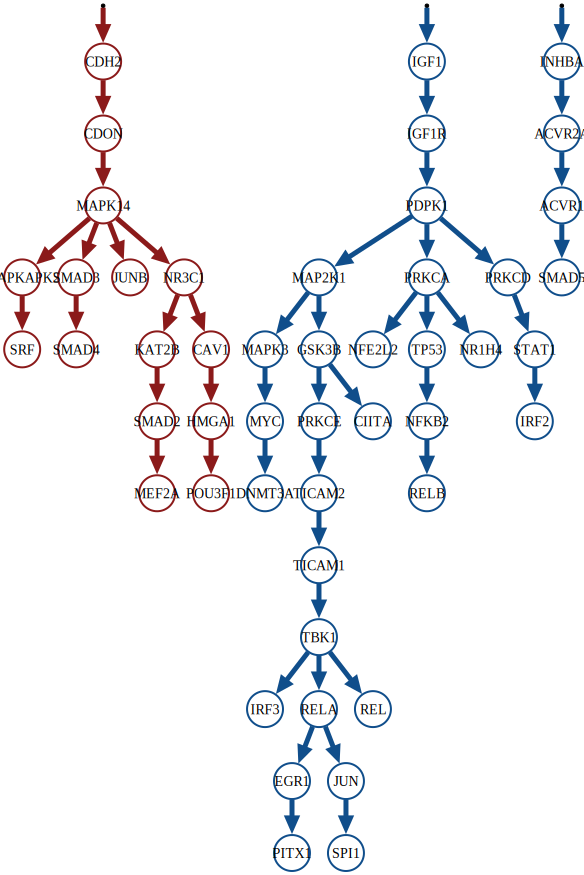

In [36]:
# We extract the selected edges. Networks are simpler,
# and they show again some activation of CDH2 and inhibition of IGF1
sol_edges = np.flatnonzero(np.abs(P.expr.edge_value.value) > 0.5)
carnival.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value,
    edge_values=P.expr.edge_value.value,
    edge_indexes=sol_edges,
)

## Other options

We included an option to simplify the networks inferred by CARNIVAL, by penalizing the selection of indirect rules. These rules are:
- A -> B in the PKN, and we observe B is downregulated, we explain it with downregulation of its upstream gene A
- A -| B in the PKN, and we observe B is upregulated, we explain it with downregulation of A

> NOTE: This is an experimental feature and was not benchmarked in the original CARNIVAL paper. 

In [37]:
carnival = CarnivalFlow(lambda_reg=0.5, indirect_rule_penalty=10)
P = carnival.build(G, data)
P.expr

Unreachable vertices for sample: 0


{'_flow': _flow: Variable((3279,), _flow),
 'edge_inhibits': edge_inhibits: Variable((3279, 1), edge_inhibits, boolean=True),
 'edge_activates': edge_activates: Variable((3279, 1), edge_activates, boolean=True),
 'const0x1735def7420c5858': const0x1735def7420c5858: Constant(CONSTANT, NONNEGATIVE, (947, 3279)),
 '_dag_layer': _dag_layer: Variable((947, 1), _dag_layer),
 'const0xb46ccbceabe3b17': const0xb46ccbceabe3b17: Constant(CONSTANT, NONNEGATIVE, (947, 3279)),
 'flow': _flow: Variable((3279,), _flow),
 'vertex_value': Expression(AFFINE, UNKNOWN, (947, 1)),
 'vertex_activated': Expression(AFFINE, NONNEGATIVE, (947, 1)),
 'vertex_inhibited': Expression(AFFINE, NONNEGATIVE, (947, 1)),
 'edge_value': Expression(AFFINE, UNKNOWN, (3279, 1)),
 'edge_has_signal': Expression(AFFINE, NONNEGATIVE, (3279, 1)),
 'vertex_max_depth': _dag_layer: Variable((947, 1), _dag_layer)}

In [38]:
P.solve(solver="highs", max_seconds=60, verbosity=1);

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 11 06:19:30 PM: Your problem has 10784 variables, 30852 constraints, and 1 parameters.
(CVXPY) Jun 11 06:19:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 06:19:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 11 06:19:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 11 06:19:30 PM: Compiling problem (target solver=HIGHS).
(CVXPY) Jun 11 06:19:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> HIGHS
(CVXPY) Jun 11 06:19:30 P

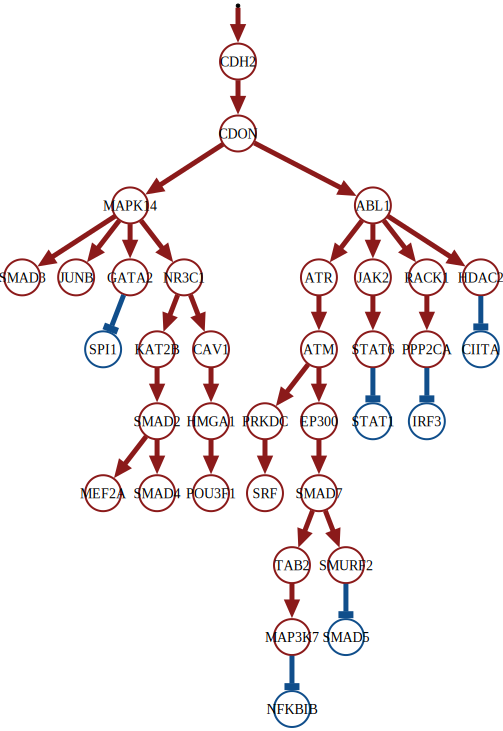

In [39]:
sol_edges = np.flatnonzero(np.abs(P.expr.edge_value.value) > 0.5)
carnival.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value,
    edge_values=P.expr.edge_value.value,
    edge_indexes=sol_edges,
)

## Using information from PROGENy

In the previous examples, we used only information from TF activities and de-regulated receptors, and we tested different options. However, results can be highly variable, due to uncertainty in the intermediate signalling proteins (downstream receptors and upstream TFs), and due to the existence of multiple paths in the PKN.

Additional information can be used to bias the reconstruction towards more plausible signalling pathways. Here, we will use information from PROGENy, which infers pathway activities from gene expression data.

In [40]:
progeny = dc.op.progeny(organism="human")
progeny

,source,target,weight,padj
0,Androgen,TMPRSS2,11.490631,2.384806e-47
1,Androgen,NKX3-1,10.622551,2.205102e-44
2,Androgen,MBOAT2,10.472733,4.632376e-44
3,Androgen,KLK2,10.176186,1.944410e-40
4,Androgen,SARG,11.386852,2.790210e-40
...,...,...,...,...
62456,p53,ENPP2,2.771405,4.993215e-02
62457,p53,ARRDC4,3.494328,4.996747e-02
62458,p53,MYO1B,-1.148057,4.997905e-02
62459,p53,CTSC,-1.784693,4.998864e-02


In [41]:
# We will use the PyDeseq2 stat as the score for the genes
de_data = results_df[["stat"]].T.rename(index={"stat": "treatment.vs.control"})
de_data

,RP11-347I19.8,TMEM170B,RP11-91P24.6,SLC33A1,SNORA61,THAP9-AS1,LIX1L,TTC8,WBSCR22,LPHN2,...,STARD4-AS1,ZNF845,NIPSNAP3B,ARL6IP5,MATN1-AS1,RP11-75I2.3,SLC25A24,BTN2A2,RP11-101E3.5,RP11-91I8.3
treatment.vs.control,-0.820242,-1.315516,-1.69062,6.990075,2.803032,1.531275,2.164138,-0.579879,-0.945672,-14.351588,...,14.484214,0.56727,-1.883272,-8.42519,-1.739921,29.760449,7.431841,-1.015945,0.508484,-4.134989


In [42]:
# Run
pw_acts, pw_padj = dc.mt.ulm(data=de_data, net=progeny)

# Filter by sign padj
msk = (pw_padj.T < 0.05).iloc[:, 0]
pw_acts = pw_acts.loc[:, msk]

pw_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,VEGF,p53
treatment.vs.control,4.784375,17.220881,11.01434,5.69894,-14.308169,25.560896,-10.195328,24.644391,59.32932,-9.129273,11.437564,-12.589745


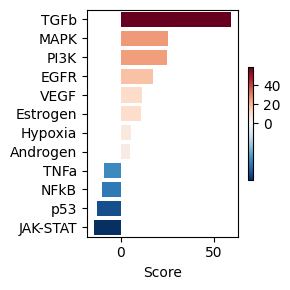

In [43]:
dc.pl.barplot(data=pw_acts, name="treatment.vs.control", top=25, figsize=(3, 3))

We can see that the TGFb pathway is predicted to be stimulated, using the observed downstream changes in gene expression. Now that we have this info, we can bias the networks towards the selection of signalling proteins in that pathway. We can check first the up/down genes in that pathway using the PROGENy network:

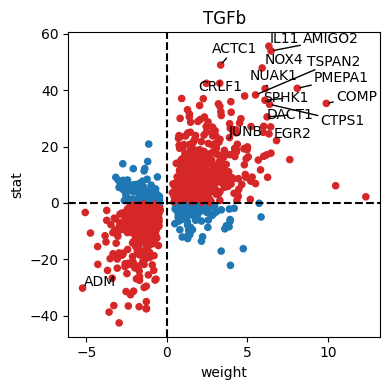

In [44]:
dc.pl.source_targets(data=results_df, x="weight", y="stat", net=progeny, name="TGFb", top=15, figsize=(4, 4))

In [45]:
df_progeny_with_de = progeny[(progeny.source == "TGFb")].set_index("target").join(results_df, rsuffix="_deseq")
df_progeny_with_de = df_progeny_with_de[(df_progeny_with_de.padj_deseq <= 1e-2) & (df_progeny_with_de.padj <= 1e-2)]

# We remove the TFs, we keep only unscored nodes in the network
df_progeny_with_de = df_progeny_with_de.loc[df_progeny_with_de.index.difference(tf_acts.columns)]
# We will calculate an score of importance, based on the weight from progeny PKN (the coefficient of importance)
# and the stat from DESeq2 for that gene in our dataset
df_progeny_with_de["score"] = df_progeny_with_de["weight"].abs() * df_progeny_with_de["stat"].abs()
df_progeny_with_de

,source,weight,padj,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj_deseq,score
ABCA6,TGFb,-3.271537,3.259776e-08,21.312146,-3.113671,0.577035,-5.395978,6.815130e-08,4.058705e-07,17.653141
ABCA8,TGFb,-1.709245,9.264710e-08,1241.936380,-2.025544,0.110001,-18.413859,1.017102e-75,6.681365e-74,31.473798
ABL1,TGFb,1.417354,6.789650e-03,11992.405040,0.654017,0.077665,8.421013,3.732418e-17,4.470195e-16,11.935557
ACOX1,TGFb,1.248375,1.198791e-04,1932.465662,0.501733,0.090449,5.547157,2.903517e-08,1.797196e-07,6.924934
ACOX3,TGFb,2.721529,3.738116e-09,1298.226294,1.249147,0.089501,13.956818,2.859170e-44,9.070311e-43,37.983882
...,...,...,...,...,...,...,...,...,...,...
ZMIZ1,TGFb,1.957381,6.461094e-05,7721.447043,0.596702,0.085546,6.975202,3.054313e-12,2.685428e-11,13.653126
ZNF281,TGFb,1.989687,3.593457e-04,2098.460557,0.586130,0.094963,6.172166,6.736069e-10,4.833421e-09,12.280681
ZNF365,TGFb,1.237670,4.895429e-03,719.298471,2.121362,0.124407,17.051793,3.389758e-65,1.797124e-63,21.104492
ZNF48,TGFb,1.745462,1.500992e-05,638.023400,0.728684,0.105677,6.895368,5.372537e-12,4.650319e-11,12.035601


In [46]:
# We will favor now the inclusion of these genes. We will
# increase lambda to get smaller networks for interpretation, and
# we will use a large penalty for indirect rules.
carnival = CarnivalFlow(lambda_reg=1.5, indirect_rule_penalty=1)
P = carnival.build(G, data)

Unreachable vertices for sample: 0


In [47]:
# We need to select the subset of genes in the processed graph, since after building carnival using the
# inputs (receptors) and TFs, the processed graph is pruned (unreachable genes removed) and thus many
# of the genes we want to score are not anymore in the graph
tgfb_genes = df_progeny_with_de.index.intersection(carnival.processed_graph.V).tolist()
len(tgfb_genes)

45

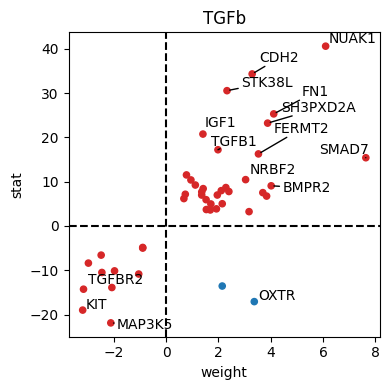

In [48]:
# We can visualize only the genes in the pruned PKN that carnival will use
# NOTE: The processed graph is the pruned PKN containing all interactions
# connecting the selected receptors to TFs, before inferring the signalling
# networks
dc.pl.source_targets(
    data=results_df.loc[tgfb_genes], x="weight", y="stat", net=progeny, name="TGFb", top=15, figsize=(4, 4)
)

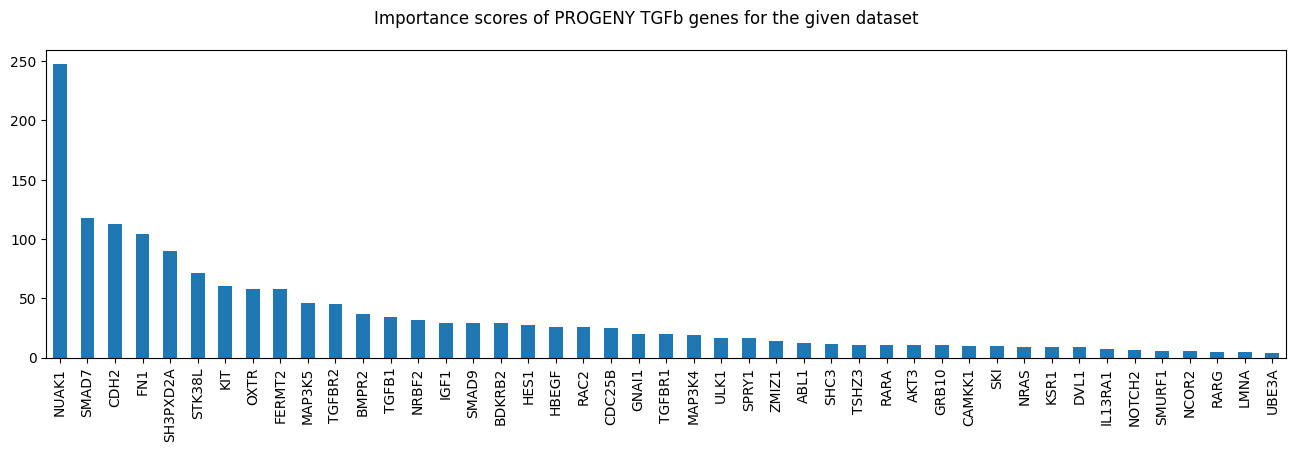

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 4))
df_progeny_with_de.loc[tgfb_genes, "score"].sort_values(ascending=False).plot.bar(ax=ax)
fig.suptitle("Importance scores of PROGENY TGFb genes for the given dataset");

In [50]:
# Scale factor for influence in the overall CARNIVAL obj function
influence_factor = 0.1

# Create the custom obj function to include in CARNIVAL
vertex_scores = np.zeros(len(carnival.processed_graph.V))
vertex_selected_var = P.expr.vertex_activated + P.expr.vertex_inhibited
for i, v in enumerate(carnival.processed_graph.V):
    if v in tgfb_genes:
        score = df_progeny_with_de.loc[v].score
        vertex_scores[i] = score
        print(i, v, score)

# The objective is just c^T @ penalties
obj = vertex_selected_var.T @ vertex_scores

# We add a negative weight to maximize selection
P.add_objective(obj, name="progeny_genes_score", weight=-influence_factor)
P.solve(solver="highs", max_seconds=60, verbosity=1);

21 NRAS 9.055651210075709
25 GNAI1 19.972682422333143
27 RAC2 25.75672169584716
44 STK38L 71.06848321367565
84 TGFBR1 19.78318967446914
101 CDH2 112.81029585047202
126 MAP3K4 18.633117866454263
148 SMURF1 5.687767369319471
189 SMAD9 29.108495622484853
208 CAMKK1 9.853578482249983
224 KIT 60.51896993721089
287 RARA 10.473371785649258
288 ULK1 16.78905409561297
295 HES1 27.774456156272613
314 UBE3A 4.198015442492376
324 SH3PXD2A 90.03028888776223
327 NOTCH2 6.0877870556111855
335 IGF1 29.197953109742727
370 NCOR2 5.253273919130532
412 ZMIZ1 13.653126134909561
434 RARG 4.459674733843175
438 IL13RA1 7.412771495771951
470 SPRY1 16.340142523123966
480 TSHZ3 10.746459209540498
533 HBEGF 25.871592750755017
538 LMNA 4.330586475862753
556 CDC25B 24.899175740820784
608 SHC3 11.348956411416047
643 DVL1 8.484789724643731
672 NRBF2 31.751626499871815
700 FN1 103.98952712958402
715 SMAD7 117.45746080491878
730 TGFBR2 45.037266815474084
749 SKI 9.483452356595494
758 GRB10 10.21623996260473
828 BDKRB2 

In [51]:
for o in P.objectives:
    print(o.name, o.value)

error_sample1_0 32.97458407452457
penalty_indirect_rules_0 [8.]
regularization_edge_has_signal 59.0
progeny_genes_score [1196.09205661]


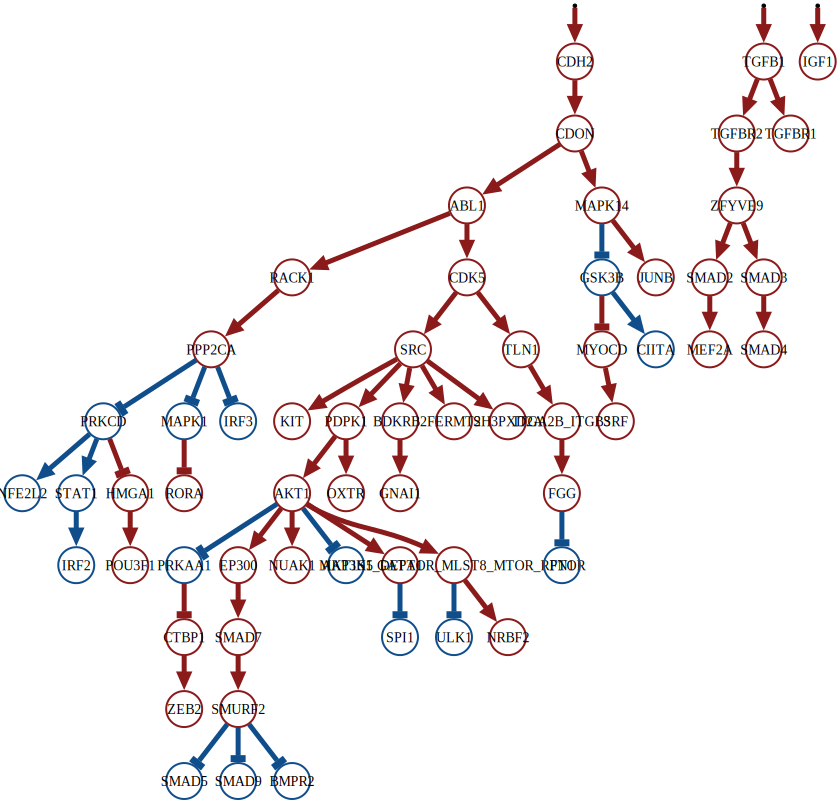

In [52]:
sol_edges = np.flatnonzero(np.abs(P.expr.edge_value.value) > 0.5)
carnival.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value,
    edge_values=P.expr.edge_value.value,
    edge_indexes=sol_edges,
)

## Advanced

Finally, we will combine CVXPY with CORNETO to add a custom objective function that uses the `cvxpy.max` to penalize the depth of the vertex in the trees. Penalizing the depth will increase the number of different receptors used indirectly.

In [53]:
import cvxpy as cp

carnival = CarnivalFlow(lambda_reg=0, indirect_rule_penalty=10)
P = carnival.build(G, data)
P.add_objective(obj, name="progeny_genes_score", weight=-influence_factor)
P.add_objective(P.expr.vertex_max_depth.apply(cp.max), weight=0.1)
P.solve(solver="highs", verbosity=1)

Unreachable vertices for sample: 0
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 11 06:19:45 PM: Your problem has 17342 variables, 30852 constraints, and 1 parameters.
(CVXPY) Jun 11 06:19:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 06:19:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 11 06:19:45 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 11 06:19:45 PM: Compiling problem (target solver=HIGHS).
(CVXPY) Jun 11 06:19:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

Problem(Minimize(Expression(CONVEX, UNKNOWN, (1,))), [Inequality(Constant(CONSTANT, ZERO, (3279,))), Inequality(Variable((3279,), _flow)), Inequality(Constant(CONSTANT, ZERO, (947, 1))), Inequality(Variable((947, 1), _dag_layer)), Equality(Expression(AFFINE, UNKNOWN, (947,)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, NONNEGATIVE, (3279, 1))), Inequality(Expression(AFFINE, NONNEGATIVE, (947, 1))), Inequality(Expression(AFFINE, UNKNOWN, (3247,))), Inequality(Expression(AFFINE, UNKNOWN, (3247,))), Inequality(Constant(CONSTANT, NONNEGATIVE, (912,))), Inequality(Expression(AFFINE, NONNEGATIVE, (3279, 1))), Inequality(Expression(AFFINE, NONNEGATIVE, (3271, 1))), Inequality(Expression(AFFINE, NONNEGATIVE, (3271, 1)))])

In [54]:
for o in P.objectives:
    print(o.name, o.value)

error_sample1_0 56.895146658866466
penalty_indirect_rules_0 [0.]
regularization_edge_has_signal 42.0
progeny_genes_score [9094.53938757]
 12.0


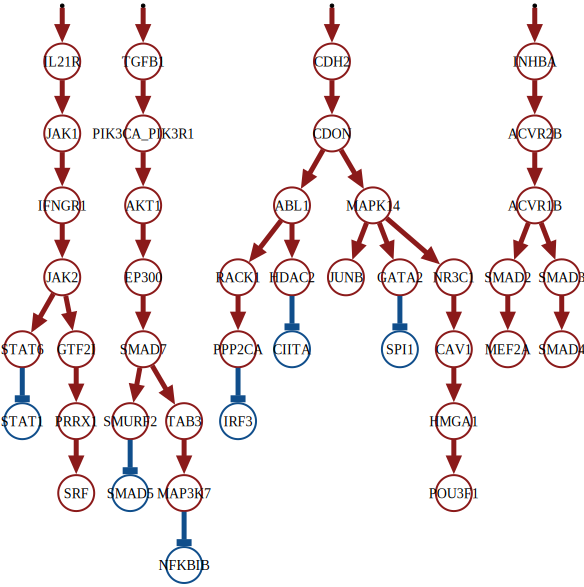

In [55]:
sol_edges = np.flatnonzero(np.abs(P.expr.edge_value.value) > 0.5)
carnival.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value,
    edge_values=P.expr.edge_value.value,
    edge_indexes=sol_edges,
)

## Saving the processed dataset

In [56]:
from corneto._data import GraphData

GraphData(G, data).save("carnival_transcriptomics_dataset")